# Data importing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt            
import seaborn as sns         

# Load the CSV file into a DataFrame
filepath = '../Input/'
file = 'FL MSDIAL MA neg.csv'

featurelist_grouped = pd.read_csv(filepath + file, sep=',', header=0)

# Display the first few rows to confirm successful loading
featurelist_grouped

,Feature,Cternatea_20692_DDA_neg_5142025_053,Cternatea_20692_DDA_neg_5142025_054,Cternatea_20692_DDA_neg_5142025_055,Cternatea_9336_DDA_neg_5142025_056,Cternatea_9336_DDA_neg_5142025_057,Cternatea_9336_DDA_neg_5142025_058,Instrument_blank_DDA_neg_5142025_060,Cternatea_QC_DDA_neg_5142025_048,Cternatea_QC_DDA_neg_5142025_049,Cternatea_QC_DDA_neg_5142025_050,Cternatea_QC_DDA_neg_5142025_051,Cternatea_QC_DDA_neg_5142025_052,Cternatea_QC_DDA_neg_5142025_059,Extraction_blank_DDA_neg_5142025_047,Instrument_blank_DDA_neg_5142025_046
0,Group,g.20692,g.20692,g.20692,g.9336,g.9336,g.9336,Blank,QC,QC,QC,QC,QC,QC,Blank,Blank
1,75.00830@0.686,108344,108264,113849,129697,142284,140111,2028,127259,123264,110246,131219,124354,131905,934,3914
2,85.02870@1.195,31168,28172,31662,28692,31719,27149,0,27776,31475,30955,21092,30225,37327,0,118
3,85.02900@0.624,21357,21363,22346,25797,27332,21597,131,17841,18411,24044,19594,19757,19149,0,0
4,87.00830@2.571,24504,24013,24306,23592,23733,21430,1518,24195,23184,22576,25273,27810,24463,986,1695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3249,1565.67060@5.728,5139,3716,4574,4504,4115,4593,0,4342,3980,3391,3103,3216,3526,0,0
3250,1577.67010@5.985,1855,1838,1583,2139,2463,1971,0,2728,2639,2907,2760,1218,1922,0,0
3251,1631.74380@5.030,248,1408,2891,1441,1865,2418,0,2695,1033,1676,959,1631,1048,0,0
3252,1639.62750@5.031,6840,6920,6271,7475,6471,6674,0,7905,7604,8006,7176,7713,7496,0,0


### Regroup if necessary

In [68]:
#Load group information
group = pd.read_excel(filepath + 'Forages selected for metabolomics_AlejandraM- from pilot.xlsx',sheet_name='Final Samples Pilot-Test March')

#Select the column for grouping
identifier = 'Substrate ID'
grouping_column = 'Methane_production' 
group = group[[identifier,grouping_column]]


# Map the 'Substrate ID' in the first row of featurelist_grouped to the 'Functional Group' in group
id_to_group = dict(zip(group[identifier], group[grouping_column]))
featurelist_grouped.iloc[0, 1:] = featurelist_grouped.iloc[0, 1:].map(id_to_group).fillna(featurelist_grouped.iloc[0, 1:])

featurelist_grouped

FileNotFoundError: [Errno 2] No such file or directory: '../Input/Forages selected for metabolomics_AlejandraM- from pilot.xlsx'

# Check for errors in data

In [2]:
# print number of features and samples
print('-----------------------------------------------------------')
print(f"Number of features: {featurelist_grouped.shape[0]-1}") # Subtract 1 for the 'feature' row
print(f"Number of samples: {featurelist_grouped.shape[1] - 1}")  # Subtract 1 for the 'feature' column
print('-----------------------------------------------------------')

# Create a new DataFrame with column names as samples and the first row of featurelist_grouped as the group each belongs to
samples_table = pd.DataFrame(columns=featurelist_grouped.columns[1:], data=[featurelist_grouped.iloc[0, 1:].values])
samples_table = samples_table.transpose()

#print name of groups and number of samples in each group
group_names = samples_table.index.tolist()
group_counts = samples_table.apply(pd.Series.value_counts).fillna(0).astype(int)
#change column name to number of samples
group_counts.columns = ['Number of samples']
print("Group names and counts:")
print('')
print(group_counts[group_counts > 0].T)
print('-----------------------------------------------------------')

# Create a feature table without the first row
feature_table = featurelist_grouped.iloc[1:, :]

# Create numeric data frame removing column feature from featurelist_grouped
numeric_data = feature_table.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')

# Check for NaN values and print the features where NaN values are present
nan_columns = numeric_data.columns[numeric_data.isna().any()].tolist()

print("Data check:")
print('')
# If NaN is found, get the row number and print the corresponding feature
if nan_columns:
    for col_name in nan_columns:
        nan_rows = numeric_data[col_name].isna()
        nan_row_indices = numeric_data[nan_rows].index.tolist()
        for row_index in nan_row_indices:
            print(f"NaN found in row {row_index}: Feature - {feature_table.loc[row_index, 'feature']}, Sample - {col_name}")
    print('')
    print(f'Procesing will continue with {len(nan_columns)} features containing NaN values.')
    
else:
    print("No NaN values found in the numeric data.")

# Filter out rows with NaN values
numeric_data = numeric_data.dropna() 
print('-----------------------------------------------------------')
feature_table = feature_table.loc[numeric_data.index]

#print number of features and samples after removing NaN values
print(f"Number of features after removing NaN values: {numeric_data.shape[0]}")
print(f"Number of samples after removing NaN values: {numeric_data.shape[1]}")
print('-----------------------------------------------------------')

-----------------------------------------------------------
Number of features: 3253
Number of samples: 15
-----------------------------------------------------------
Group names and counts:

                   QC  g.20692  g.9336  Blank
Number of samples   6        3       3      3
-----------------------------------------------------------
Data check:

No NaN values found in the numeric data.
-----------------------------------------------------------
Number of features after removing NaN values: 3253
Number of samples after removing NaN values: 15
-----------------------------------------------------------


### Filter groups if necessary

In [3]:
# Select groups to filter out
groups_to_filter = ['Blank']

# Create a mask to filter out the specified groups
mask = samples_table[0].isin(groups_to_filter)

# Filter the numeric data and feature table
numeric_data = numeric_data.loc[:, ~mask]
feature_table = feature_table.loc[numeric_data.index]
samples_table = samples_table.loc[~mask]

#print name of groups and number of samples in each group
group_names = samples_table.index.tolist()
group_counts = samples_table.apply(pd.Series.value_counts).fillna(0).astype(int)
#change column name to number of samples
group_counts.columns = ['Number of samples']
print("Group names and counts:")
print('')
print(group_counts[group_counts > 0].T)
print('-----------------------------------------------------------')

Group names and counts:

                   QC  g.20692  g.9336
Number of samples   6        3       3
-----------------------------------------------------------


In [108]:
# Fill all 0 in numeric data with 1/5 of the minimum value of the corresponding row
for index, row in numeric_data.iterrows():
    min_value = row[row > 0].min()  # Get the minimum value greater than 0
    if min_value > 0:
        numeric_data.loc[index] = row.replace(0, min_value / 5)  # Replace 0 with 1/5 of the minimum value

#print(numeric_data.head())


# Scaling of data

There are 4 types of scaling: 

**Mean centering**	(mean-centered only)

**Auto scaling**	(mean-centered and divided by the standard deviation of each variable)

**Pareto scaling**	(mean-centered and divided by the square root of the standard deviation of each variable)

**Range scaling**	(mean-centered and divided by the range of each variable)

or use **None** to work with no scaled data


In [4]:
import matplotlib.pyplot as plt
import pandas as pd

def scale_data(df, scaling_type):
    """
    Scale the data based on the specified scaling type and plot density before and after scaling.

    Parameters:
    df (pd.DataFrame): The input DataFrame to scale.
    scaling_type (str): The type of scaling to apply. Options are:
                        'none', 'mean_centering', 'auto', 'pareto', 'range'.                    

    Returns:
    pd.DataFrame: The scaled DataFrame.
    """
    df.drop(columns=['Feature'], inplace=True, errors='ignore')  # Drop the 'Feature' column if it exists
    df = df.astype(float)  # Convert all columns to float for scaling

    # Combine all columns into a single series for density plot
    combined_before = df.values.flatten()

    # Apply scaling row by row
    scaled_df = pd.DataFrame(index=df.index, columns=df.columns)
    for idx, row in df.iterrows():
        if scaling_type == 'none':
            scaled_df.loc[idx] = row
        elif scaling_type == 'mean_centering':
            scaled_df.loc[idx] = row - row.mean()
        elif scaling_type == 'auto':
            if row.std() == 0:
                scaled_df.loc[idx] = row
            else:
                scaled_df.loc[idx] = (row - row.mean()) / row.std()
        elif scaling_type == 'pareto':
            if row.std() == 0:
                scaled_df.loc[idx] = row
            else:
                scaled_df.loc[idx] = (row - row.mean()) / (row.std() ** 0.5)
        elif scaling_type == 'range':
            scaled_df.loc[idx] = (row - row.mean()) / (row.max() - row.min())
        else:
            raise ValueError("Invalid scaling type. Choose from 'none', 'mean_centering', 'auto', 'pareto', 'range'.")

    # Combine all columns into a single series for density plot after scaling
    combined_after = scaled_df.values.flatten()

        # Plot density before and after scaling side by side
    fig, axes = plt.subplots(2, 2, figsize=(8, 8), gridspec_kw={'height_ratios': [1, 2.5]})

    # Density before scaling
    axes[0,0].set_title("Before Scaling")
    axes[0,0].set_ylabel("Density")
    axes[0,0].grid(True)
    pd.Series(combined_before).plot.kde(ax=axes[0,0], label="Before Scaling", linewidth=2, bw_method=1, color='blue')

    # Density after scaling
    axes[0,1].set_title("After Scaling")
    axes[0,1].set_ylabel("Density")
    axes[0,1].grid(True)
    pd.Series(combined_after).plot.kde(ax=axes[0,1], label="After Scaling", linewidth=2, bw_method=1, color='orange')
    if scaling_type == 'none':
        axes[0,1].set_xlim()
    elif scaling_type == 'mean_centering':
        axes[0,1].set_xlim(-np.min(combined_before)-np.mean(combined_before), np.max(combined_before)-np.mean(combined_before))
    elif scaling_type == 'auto':
        axes[0,1].set_xlim(-np.median(combined_before)*1.2, np.median(combined_before)*1.2)
    elif scaling_type == 'pareto':
        axes[0,1].set_xlim(-10000, 10000)
    elif scaling_type == 'range':
        axes[0,1].set_xlim(-5, 5)

    # plot boxplot of first 10 rows, scaled and unscaled, row by row
    #fig, axes = plt.subplots(1, 2, figsize=(10, 8))
    # Boxplot before scaling
    axes[1,0].set_title("Before Scaling")
    axes[1,0].grid(True)
    axes[1,0].set_yticklabels([])
    sns.boxplot(data=df.T.iloc[:, :25], ax=axes[1,0], orient='horizontal', color='blue')
    # Boxplot after scaling
    axes[1,1].set_title("After Scaling")
    axes[1,1].grid(True)
    axes[1,1].set_yticks([])
    axes[1,1].set_yticklabels([])
    sns.boxplot(data=scaled_df.T.iloc[:, :25], ax=axes[1,1], orient='horizontal', color='orange')
    plt.tight_layout()
    plt.show()

    return scaled_df

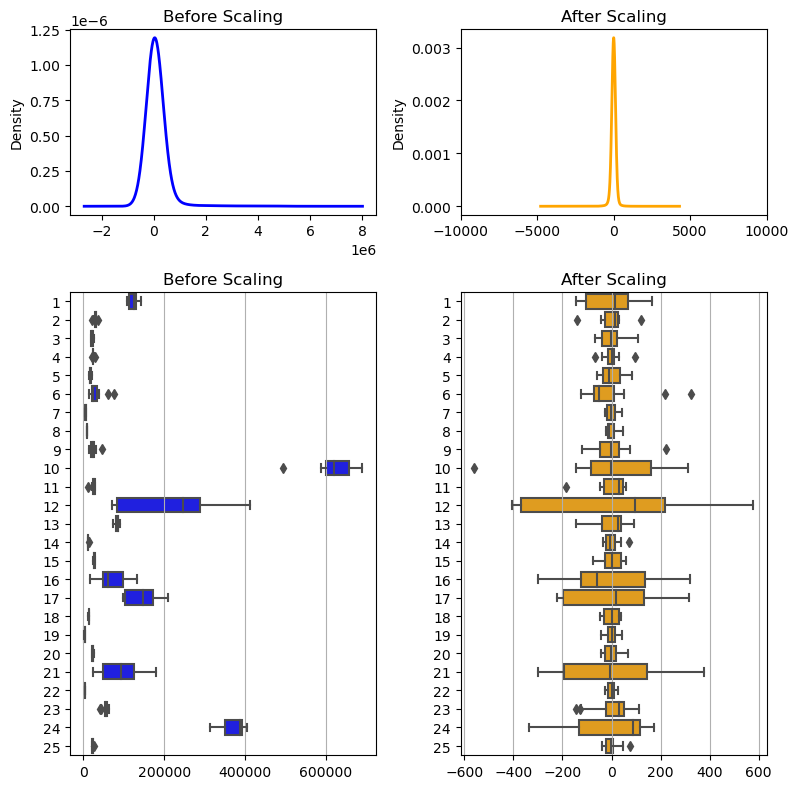

In [5]:
# Scaling 
scaling_type = 'pareto'  # Change this to 'none', 'mean_centering', 'auto', 'pareto', or 'range'
scaled_featurelist_grouped = scale_data(numeric_data, scaling_type)

# PCA 

<Figure size 1200x700 with 0 Axes>

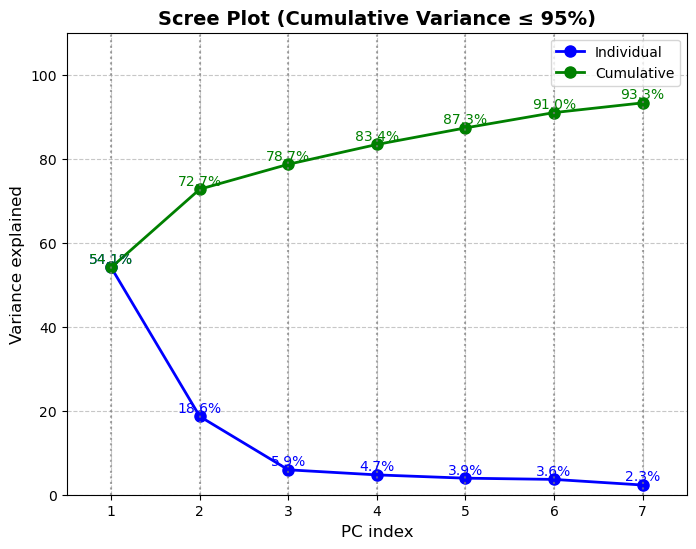

In [6]:
from sklearn.decomposition import PCA

# Perform PCA
pca = PCA()
pca_result = pca.fit_transform(scaled_featurelist_grouped.T)

# Create a DataFrame for PCA results
PCA_data = pd.DataFrame(pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

# Add the sample names as the first column using the columns of scaled_featurelist_grouped
PCA_data.insert(0, 'sample', scaled_featurelist_grouped.columns)

# Add the group names as the second column using the index of samples_table
PCA_data.insert(1, 'group', samples_table.loc[scaled_featurelist_grouped.columns].values)

#calculate explained variance
explained_variance = pca.explained_variance_ratio_ * 100
# Create a DataFrame for explained variance
explained_variance_df = pd.DataFrame({
    'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance))],
    'Explained Variance (%)': explained_variance
})

def plot_scree(df):
    # Extract explained variance values
    explained_variance = df['Explained Variance (%)'].values
    cumulative_variance = np.cumsum(explained_variance)
    
    # Create figure
    plt.figure(figsize=(12, 7))
    pc_indices = np.arange(1, len(explained_variance) + 1)
     
    # Filter the explained variance data to include only components until cumulative variance reaches 90%
    explained_variance_df['Cumulative Variance (%)'] = np.cumsum(explained_variance_df['Explained Variance (%)'])
    filtered_df = explained_variance_df[explained_variance_df['Cumulative Variance (%)'] <= 95]

    # Plot the filtered scree plot
    plt.figure(figsize=(8, 6))
    pc_indices = np.arange(1, len(filtered_df) + 1)

    # Plot individual and cumulative variance
    plt.plot(pc_indices, filtered_df['Explained Variance (%)'], 'bo-', linewidth=2, markersize=8, label='Individual')
    plt.plot(pc_indices, filtered_df['Cumulative Variance (%)'], 'go-', linewidth=2, markersize=8, label='Cumulative')

    # Add vertical reference lines
    for i in pc_indices:
        plt.axvline(x=i, color='gray', linestyle=':', alpha=0.7)

    # Annotate the points
    for i in range(len(filtered_df)):
        plt.text(pc_indices[i], filtered_df['Explained Variance (%)'].iloc[i] + 1, 
                 f"{filtered_df['Explained Variance (%)'].iloc[i]:.1f}%", ha='center', color='blue')
        plt.text(pc_indices[i], filtered_df['Cumulative Variance (%)'].iloc[i] + 1, 
                 f"{filtered_df['Cumulative Variance (%)'].iloc[i]:.1f}%", ha='center', color='green')

    # Set up plot attributes
    plt.title('Scree Plot (Cumulative Variance ≤ 95%)', fontsize=14, fontweight='bold')
    plt.xlabel('PC index', fontsize=12)
    plt.ylabel('Variance explained', fontsize=12)
    plt.ylim(0, 110)
    plt.xlim(0.5, len(filtered_df) + 0.5)
    plt.xticks(pc_indices)
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
plot_scree(explained_variance_df)



#### plot 2D

C:\Users\User\AppData\Local\Temp\ipykernel_11940\4153361155.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Set1', len(unique_labels))  # Use 'Set1' for distinctive colors
C:\Users\User\AppData\Local\Temp\ipykernel_11940\4153361155.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map['raw'] = plt.cm.get_cmap('Set2')(0)  # Replace 'green' with the first color in 'Set2'


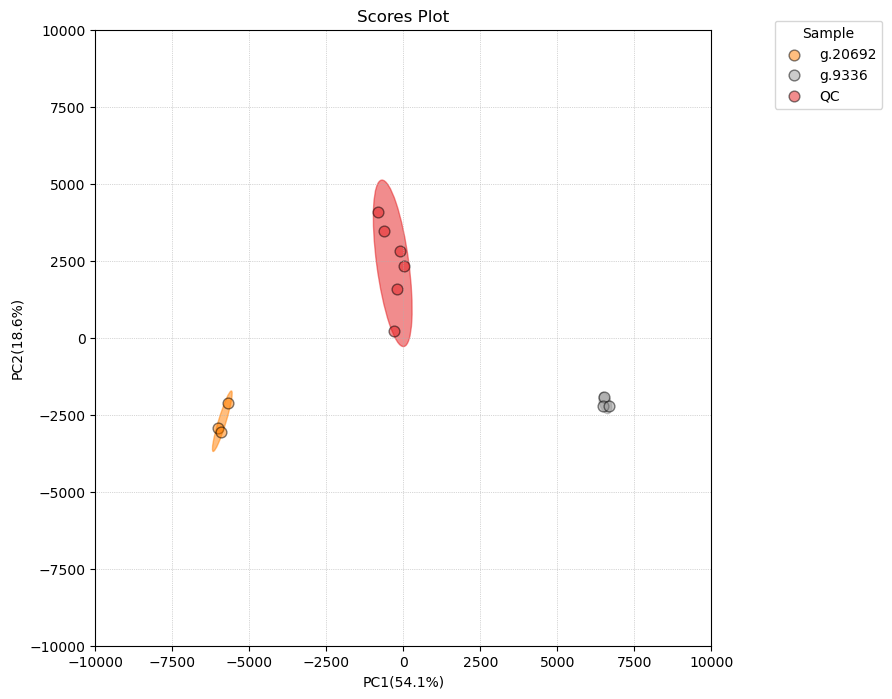

In [11]:
# Extraer las columnas necesarias
x = PCA_data['PC1']
y = PCA_data['PC2']
labels = PCA_data['group']  # Extraer la primera palabra antes del guion bajo

# Obtener los nombres únicos de las etiquetas
unique_labels = labels.unique()

# Definir colores automáticamente usando una paleta de Matplotlib en orden
cmap = plt.cm.get_cmap('Set1', len(unique_labels))  # Use 'Set1' for distinctive colors
color_map = {label: cmap(i) for i, label in enumerate(sorted(unique_labels))}

# Si deseas establecer algunos colores manualmente, puedes hacerlo aquí
color_map['raw'] = plt.cm.get_cmap('Set2')(0)  # Replace 'green' with the first color in 'Set2'
color_map['Translucido'] = 'lightgreen'  # Otro ejemplo
color_map['Blanco'] = 'gray'  # Ejemplo de establecimiento manual
color_map['Marron'] = 'brown'  # Otro ejemplo
color_map['Amarillo'] = 'yellow'  # Otro ejemplo

# Graficar
plt.figure(figsize=(8, 8))  # Tamaño cuadrado
plt.grid(which='both', linestyle=':', linewidth=0.5)  # Grid punteado

# Crear elipses para el rango de confianza del 95%

for label in unique_labels:
    mask = labels == label
    x_group = x[mask]
    y_group = y[mask]

    # Verifica si el grupo tiene suficientes puntos
    if len(x_group) < 2:
        continue

    # Calcular media y covarianza
    mean = np.mean(x_group), np.mean(y_group)
    cov = np.cov(x_group, y_group)
    
    # Calcular los eigenvalores y eigenvectores
    eigenvalues, eigenvectors = np.linalg.eig(cov)

    # Calcular el ángulo de la elipse
    angle = np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0])
    angle = np.degrees(angle)

    # Calcular el ancho y alto de la elipse (95% de confianza)
    width, height = 2 * 1.96 * np.sqrt(eigenvalues)

    # Dibujar la elipse
    ellipse = plt.matplotlib.patches.Ellipse(mean, width, height, angle=angle, 
                                              color=color_map[label], alpha=0.5)
    plt.gca().add_patch(ellipse)

    # Graficar los puntos
    plt.scatter(x_group, y_group, label=label, color=color_map[label], edgecolor='black', alpha=0.5, s=60)

plt.title('Scores Plot')
plt.xlabel(f'PC1({explained_variance[0]:.1f}%)')
plt.ylabel(f'PC2({explained_variance[1]:.1f}%)')

# Configurar la leyenda fuera del gráfico
plt.legend(loc='upper right', bbox_to_anchor=(1.12, 0.9), title="Sample", bbox_transform=plt.gcf().transFigure)

# Evitar notación científica en el eje y
plt.ticklabel_format(style='plain', axis='y')


plt.axis('square')  # Asegura que el gráfico sea cuadrado
plt.ylim(-10000, 10000) 
plt.xlim(-10000, 10000) 
# Guardar el gráfico
output_file = f'../Output/PCA/{file}_PCA2D.png'
plt.savefig(output_file, bbox_inches='tight', dpi=400)

plt.show()

#### plot 3D

C:\Users\User\AppData\Local\Temp\ipykernel_11940\44757799.py:24: RuntimeWarning: invalid value encountered in sqrt
  width, height, depth = 2 * 1.96 * np.sqrt(eigenvalues)


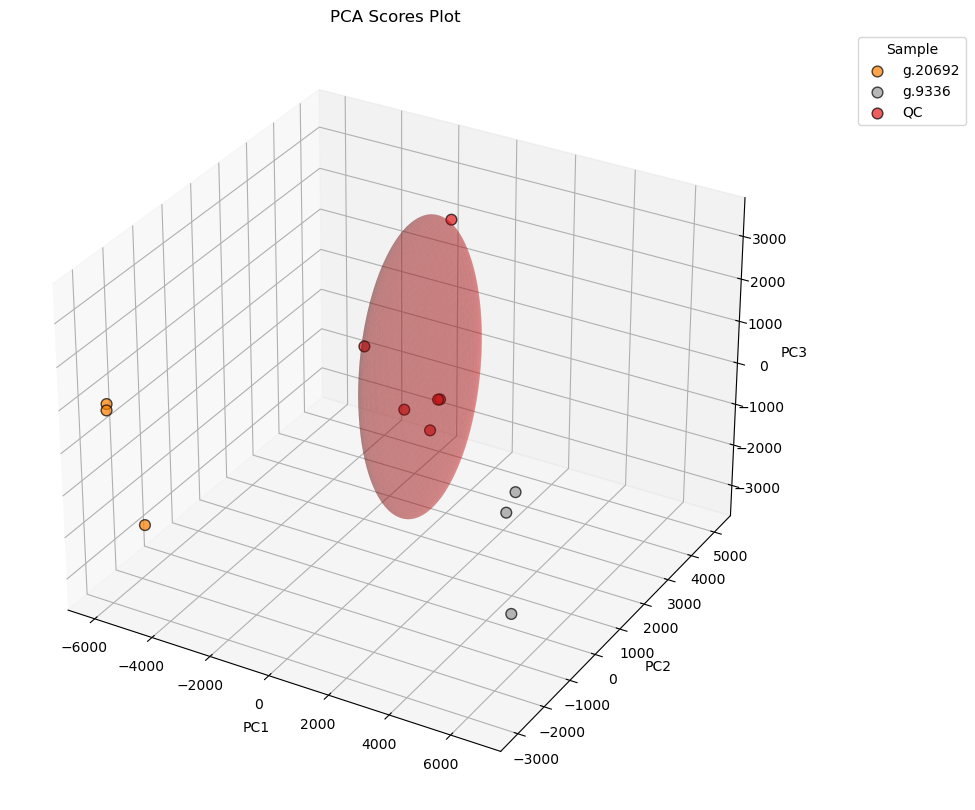

In [8]:
z= PCA_data['PC3']

# Graficar
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_facecolor('white')

# Crear elipses para el rango de confianza del 95%
for label in unique_labels:
    mask = labels == label
    x_group = x[mask]
    y_group = y[mask]
    z_group = z[mask]

    if len(x_group) < 2:
        continue

    mean = np.mean(x_group), np.mean(y_group), np.mean(z_group)
    cov = np.cov(np.vstack([x_group, y_group, z_group]), rowvar=True)

    eigenvalues, eigenvectors = np.linalg.eig(cov)

    # Calcular el ancho, alto y profundidad de la elipsoide (95% de confianza)
    width, height, depth = 2 * 1.96 * np.sqrt(eigenvalues)

    # Crear puntos para la elipsoide
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    # Coordenadas esféricas
    x_sphere = (width / 2) * np.outer(np.cos(u), np.sin(v))
    y_sphere = (height / 2) * np.outer(np.sin(u), np.sin(v))
    z_sphere = (depth / 2) * np.outer(np.ones(np.size(u)), np.cos(v))

    # Transformar usando los eigenvectores
    ellipsoid_points = np.dot(eigenvectors, np.vstack([x_sphere.flatten(), y_sphere.flatten(), z_sphere.flatten()]))

    # Desplazar a la posición media
    x_ellipsoid = ellipsoid_points[0, :] + mean[0]
    y_ellipsoid = ellipsoid_points[1, :] + mean[1]
    z_ellipsoid = ellipsoid_points[2, :] + mean[2]

    # Dibujar la elipsoide
    ax.plot_surface(x_ellipsoid.reshape(x_sphere.shape),
                    y_ellipsoid.reshape(y_sphere.shape),
                    z_ellipsoid.reshape(z_sphere.shape),
                    color=color_map[label], alpha=0.3)

    # Graficar los puntos
    ax.scatter(x_group, y_group, z_group, label=label, color=color_map[label], edgecolor='black', alpha=0.7, s=60)

ax.set_title('PCA Scores Plot')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Configurar la leyenda
ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.0), title="Sample")

# Guardar el gráfico
output_file = f'../Output/PCA/{file}_PCA3D.png'
plt.savefig(output_file, bbox_inches='tight', dpi=400)

plt.show()

### HTML PCA PLOT 3D

In [81]:
import plotly.express as px
import pandas as pd

#define colors and labels
colors = PCA_data['group']
labels = PCA_data['sample'].str.split('_').str[5] 

# Crear un DataFrame con los datos
df = pd.DataFrame({
    'PC1': x,
    'PC2': y,
    'PC3': z,
    'Label': labels,
    'color': colors
})

# Crear un gráfico 3D interactivo
fig = px.scatter_3d(df, 
                    x='PC1', 
                    y='PC2', 
                    z='PC3', 
                    color='color',  # Use the 'color' column for coloring
                    hover_name='Label',  # Use the 'Label' column for hover text
                    title='3D PCA Scores Plot',
                    color_discrete_sequence=px.colors.qualitative.Set1)

# Personalizar el diseño
fig.update_traces(marker=dict(size=5))  # Tamaño de los puntos
fig.update_layout(scene=dict(
                    xaxis_title='PC1',
                    yaxis_title='PC2',
                    zaxis_title='PC3'),
                  legend_title='Labels')

# Guardar el gráfico en un archivo HTML
output_file = f'../Output/PCA/{file}_PCA3D.html'
fig.write_html(output_file)

print(f'Gráfico guardado en: {output_file}')


Gráfico guardado en: ../Output/PCA/FL MSDIAL MA neg.csv_PCA3D.html


# Volcano plot

In [115]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

group1 = 'Cooked' # Define the first group (upregulated group)
group2 = 'raw' # Define the second group (downregulated group)

# Extract the feature names from the feature_table
features = feature_table['feature']

# Calculate Fold Change (FC) as the ratio of means between 'raw' and 'Cooked' groups
group_means = numeric_data.groupby(samples_table[0], axis=1).mean()
fc = group_means.loc[:, group1] / group_means.loc[:, group2]

# Calculate log2(FC)
log2_fc = np.log2(fc)

# Perform t-test between 'raw' and 'Cooked' groups for each feature
raw_group = numeric_data.loc[:, samples_table[samples_table[0] == group1].index]
cooked_group = numeric_data.loc[:, samples_table[samples_table[0] == group2].index]

# Calculate p-values using t-test
_, raw_pvals = ttest_ind(raw_group, cooked_group, axis=1, equal_var=True, nan_policy='omit')

# Calculate -log10(p)
neg_log10_p = -np.log10(raw_pvals)

# Create the final DataFrame
volcano_df = pd.DataFrame({
    'feature': features,
    'FC': fc,
    'log2(FC)': log2_fc,
    'raw.pval': raw_pvals,
    '-log10(p)': neg_log10_p
})

# Display the first few rows of the DataFrame
#print(volcano_df.head())

KeyError: 'feature'

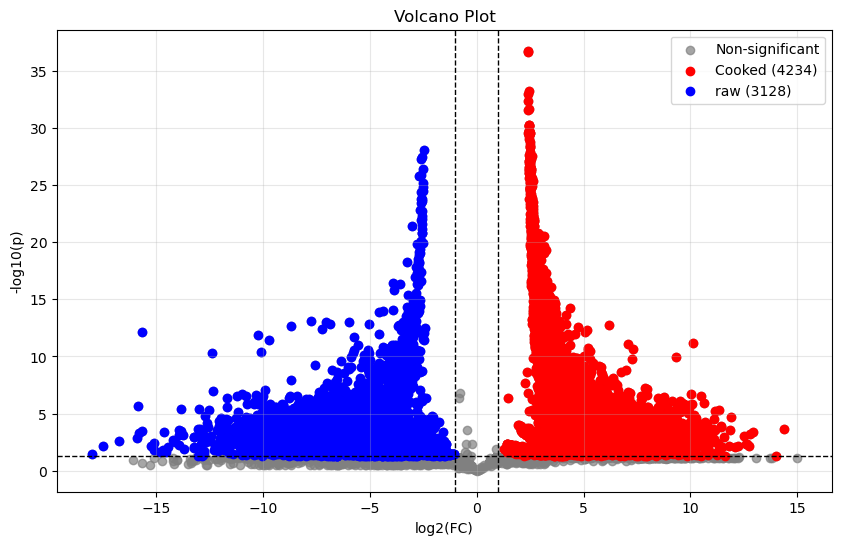

In [91]:
# Configurar los valores de corte
fc_cutoff = 2
p_cutoff = 0.05
log2_fc_cutoff = np.log2(fc_cutoff)
neg_log10_p_cutoff = -np.log10(p_cutoff)

# Crear el volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(volcano_df['log2(FC)'], volcano_df['-log10(p)'], c='gray', alpha=0.7, label='Non-significant')

# Resaltar puntos significativos
significant_up = (volcano_df['log2(FC)'] > log2_fc_cutoff) & (volcano_df['-log10(p)'] > neg_log10_p_cutoff)
significant_down = (volcano_df['log2(FC)'] < -log2_fc_cutoff) & (volcano_df['-log10(p)'] > neg_log10_p_cutoff)

plt.scatter(volcano_df.loc[significant_up, 'log2(FC)'], volcano_df.loc[significant_up, '-log10(p)'], c='red', label=f'{group1} ({len(volcano_df.loc[significant_up])})')
plt.scatter(volcano_df.loc[significant_down, 'log2(FC)'], volcano_df.loc[significant_down, '-log10(p)'], c='blue', label=f'{group2} ({len(volcano_df.loc[significant_down])})')

# Etiquetas y líneas de corte
plt.axhline(y=neg_log10_p_cutoff, color='black', linestyle='--', linewidth=1, label=f'p = 0.05 (-log10(p) = {neg_log10_p_cutoff:.2f})')
plt.axvline(x=log2_fc_cutoff, color='black', linestyle='--', linewidth=1, label=f'log2(FC) = {log2_fc_cutoff}')
plt.axvline(x=-log2_fc_cutoff, color='black', linestyle='--', linewidth=1)

plt.xlabel('log2(FC)')
plt.ylabel('-log10(p)')
plt.title('Volcano Plot')
# Update legend to exclude lines
handles, labels = plt.gca().get_legend_handles_labels()
filtered_handles = [h for h, l in zip(handles, labels) if 'log2(FC)' not in l and 'p = 0.05' not in l]
filtered_labels = [l for l in labels if 'log2(FC)' not in l and 'p = 0.05' not in l]
plt.legend(filtered_handles, filtered_labels)
plt.grid(alpha=0.3)
plt.show()

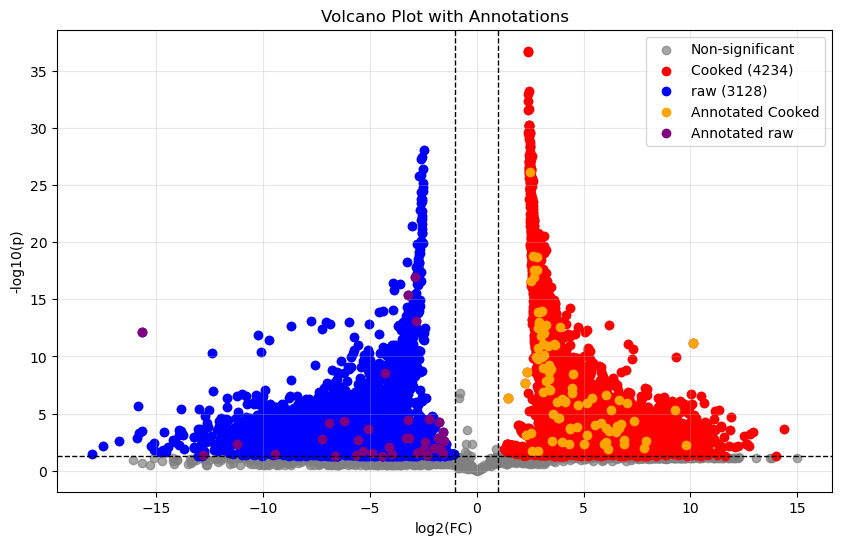

In [92]:
# Filter for annotated upregulated and downregulated points
annotated_up = volcano_df[~volcano_df['feature'].str.contains('@', na=False) & significant_up]
annotated_down = volcano_df[~volcano_df['feature'].str.contains('@', na=False) & significant_down]

# Create the volcano plot
plt.figure(figsize=(10, 6))
plt.scatter(volcano_df['log2(FC)'], volcano_df['-log10(p)'], c='gray', alpha=0.7, label='Non-significant')

# Highlight significant points
plt.scatter(volcano_df.loc[significant_up, 'log2(FC)'], volcano_df.loc[significant_up, '-log10(p)'], c='red', label=f'{group1} ({len(volcano_df.loc[significant_up])})')
plt.scatter(volcano_df.loc[significant_down, 'log2(FC)'], volcano_df.loc[significant_down, '-log10(p)'], c='blue', label=f'{group2} ({len(volcano_df.loc[significant_down])})')

# Highlight annotated points with different colors
plt.scatter(annotated_up['log2(FC)'], annotated_up['-log10(p)'], c='orange', label=f'Annotated {group1}')
plt.scatter(annotated_down['log2(FC)'], annotated_down['-log10(p)'], c='purple', label=f'Annotated {group2}')

# Add cutoff lines
plt.axhline(y=neg_log10_p_cutoff, color='black', linestyle='--', linewidth=1, label=f'p = 0.05 (-log10(p) = {neg_log10_p_cutoff:.2f})')
plt.axvline(x=log2_fc_cutoff, color='black', linestyle='--', linewidth=1, label=f'log2(FC) = {log2_fc_cutoff}')
plt.axvline(x=-log2_fc_cutoff, color='black', linestyle='--', linewidth=1)

# Labels and title
plt.xlabel('log2(FC)')
plt.ylabel('-log10(p)')
plt.title('Volcano Plot with Annotations')

# Update legend to include annotations
handles, labels = plt.gca().get_legend_handles_labels()
filtered_handles = [h for h, l in zip(handles, labels) if 'log2(FC)' not in l and 'p = 0.05' not in l]
filtered_labels = [l for l in labels if 'log2(FC)' not in l and 'p = 0.05' not in l]
plt.legend(filtered_handles, filtered_labels)

plt.grid(alpha=0.3)
plt.show()

In [93]:
# Print the number of annotated upregulated and downregulated features
print(f"Number of annotated upregulated features({group1}): {len(annotated_up)}")
print(f"Number of annotated downregulated features({group2}): {len(annotated_down)}")

Number of annotated upregulated features(Cooked): 89
Number of annotated downregulated features(raw): 39


In [94]:
from IPython.display import display

# order the features by their FC values
annotated_up = annotated_up.sort_values(by='log2(FC)', ascending=False)
annotated_down = annotated_down.sort_values(by='log2(FC)', ascending=True)

# Style and display the upregulated table
print("Upregulated Table Annotated:")
styled_upregulated = annotated_up[['log2(FC)', '-log10(p)', 'feature']].style.set_table_attributes("style='display:inline'").set_caption(f'[{group1}] Upregulated Table Annotated')
display(styled_upregulated)

# Style and display the downregulated table
print("\nDownregulated Table Annotated:")
styled_downregulated = annotated_down[['log2(FC)', '-log10(p)','feature']].style.set_table_attributes("style='display:inline'").set_caption(f'[{group2}] Downregulated Table Annotated')
display(styled_downregulated)

Upregulated Table Annotated:


,log2(FC),-log10(p),feature
113,10.099550,11.207648,Maleic acid_neg
83,9.807287,2.259878,NP-001383_neg
71,9.289893,5.310048,NP-015807_neg
1604,7.927127,2.603141,"7-Hydroxy-8,11,13-abietatrien-19-oic acid_neg"
79,7.815713,2.013742,NP-003388_neg
24,7.363443,4.355658,Syringic acid_neg
136,7.048426,5.940437,Hypoxanthine_pos
42,6.866302,2.303145,Quercetin_pos
97,6.865598,2.676738,Naringenin chalcone_neg
12002,6.768929,4.101288,"2-(3,4-dihydroxyphenyl)-3,5,7-trihydroxy-4H-chromen-4-one_pos"



Downregulated Table Annotated:


,log2(FC),-log10(p),feature
11998,-15.679558,12.104882,"2,6-Diemthyl-pyridine_pos"
137,-12.809289,1.336089,Hydroxymethylglutaric acid_neg
70,-11.226889,2.355226,NP-016768_pos
96,-9.463536,1.502885,Naringenin_neg
2453,-7.229590,2.735863,6-Gingerol_neg
67,-6.918924,4.151502,NP-021146_pos
43,-6.641459,1.312460,Quercetin_neg
5655,-6.217261,4.381893,4-Hydroxybenzoic acid_pos
62,-5.639945,1.417008,NP-026098_neg
13881,-5.540325,2.651587,"(Z)-5,8,11-trihydroxyoctadec-9-enoic acid_neg"
